In [16]:
from gloria.datasets.visualization_utils import *
from gloria.datasets.mimic_data import MimicCxrFiler, ImaGenomeFiler, ImaGenomeDataModule
from gloria.datasets.mimic_for_gloria import GloriaCollateFn
from gloria.lightning.callbacks import EvaluateLocalization

In [17]:
mimic_cxr_filer = MimicCxrFiler(
    download_directory='/scratch/mcinerney.de/mimic-cxr', physio_username='dmcinerney')
imagenome_filer = ImaGenomeFiler(
    download_directory='/scratch/mcinerney.de/imagenome', physio_username='dmcinerney',
    physio_password=mimic_cxr_filer.password)

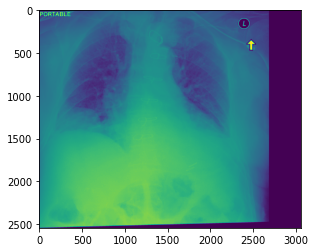

In [25]:
img= mimic_cxr_filer.get_ptimage(dm.val.df[dm.val.df.dicom_id == '0022dda5-02696575-c2dc91e3-4756809d-5af66691'].iloc[0])
plt.imshow(img)


In [10]:
dm = ImaGenomeDataModule(
    mimic_cxr_filer, imagenome_filer, batch_size=8, num_workers=5, collate_fn=None,
    get_images=True, get_reports=True, force=False, parallel=True,
    num_preprocessing_workers=os.cpu_count(), chunksize=1, split_slices='', gold_test=False)

dm.prepare_data()

downloaded


In [ ]:
collate_fn = GloriaCollateFn(cfg, "test")
EvaluateLocalization(collate_fn, 'sample')

In [15]:
from gloria.lightning.pretrain_model import PretrainModel
module = PretrainModel.load_from_checkpoint('./pretrained/chexpert_resnet50.ckpt')

In [ ]:
trainer = Trainer(gpus='0', callbacks=[])

In [11]:
valid = dm.get_dataset('valid')
valid_shuffle_sentence_labels = dm.get_dataset('valid', randomize_objects_mode='shuffle_bboxes_sentences')
valid_random_sentence_labels = dm.get_dataset('valid', randomize_objects_mode='random_bboxes')
valid_random_sentences = dm.get_dataset('valid', randomize_objects_mode='random_sentences')
valid.df

,Unnamed: 0,Unnamed: 0.1,subject_id,study_id,dicom_id,path,ViewPosition,sent_ids
0,11503,11503,14811141,53107220,26b72926-4afaa4c9-b24ece3a-ee2a554a-4add0f4a,files/p14/p14811141/s53107220/26b72926-4afaa4c...,AP,"['53107220|7', '53107220|8']"
1,17883,17883,17465349,53985143,06dd1661-bedb1638-6e9a2c06-036adf6c-86177ab3,files/p17/p17465349/s53985143/06dd1661-bedb163...,AP,"['53985143|3', '53985143|4']"
2,17884,17884,17465349,54097536,a5f6bb53-ea00c3d0-3ef1fe3c-baa95cd1-362be990,files/p17/p17465349/s54097536/a5f6bb53-ea00c3d...,AP,"['54097536|3', '54097536|4', '54097536|5', '54..."
3,17885,17885,17465349,59544755,2333f8e2-a30d730e-046db2fc-3c955522-1811a4cb,files/p17/p17465349/s59544755/2333f8e2-a30d730...,AP,"['59544755|4', '59544755|5', '59544755|6', '59..."
4,12457,12457,15138835,53497105,848bd703-b46b11c6-877b7be4-65899c93-2e751d5f,files/p15/p15138835/s53497105/848bd703-b46b11c...,PA,"['53497105|5', '53497105|6', '53497105|7']"
...,...,...,...,...,...,...,...,...
23948,10949,10949,14614509,58872646,05a5b181-a16edc55-42bf77b0-27f98b72-3a72cabe,files/p14/p14614509/s58872646/05a5b181-a16edc5...,PA,"['58872646|7', '58872646|8', '58872646|9', '58..."
23949,10950,10950,14614509,58872646,0f3782bb-104759ae-1f86b7c0-acd6322b-b5502dbd,files/p14/p14614509/s58872646/0f3782bb-104759a...,AP,"['58872646|7', '58872646|8', '58872646|9', '58..."
23950,19003,19003,17956850,51547050,244b954b-73a62277-3776411f-a4b2f412-be720a97,files/p17/p17956850/s51547050/244b954b-73a6227...,AP,"['51547050|6', '51547050|7', '51547050|8', '51..."
23951,19004,19004,17956850,54469510,f72b904b-fc701e8d-93056771-2f935034-032ba240,files/p17/p17956850/s54469510/f72b904b-fc701e8...,AP,"['54469510|6', '54469510|7', '54469510|8', '54..."


In [3]:
dm = ImaGenomeDataModule(
    mimic_cxr_filer, imagenome_filer, batch_size=8, num_workers=5, collate_fn=None,
    get_images=True, get_reports=True, force=False, parallel=False,
    num_preprocessing_workers=os.cpu_count(), chunksize=1, split_slices='', gold_test=False)

dm.prepare_data()

downloaded
extracted
not parallelizing


  0%|                                                                                                                                                                             | 0/12538 [00:00<?, ?it/s]

Setting one record's processing to verbose to serve as an example.

Filter dicoms so view position is '['PA', 'AP']':



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 1122.15it/s]



Save dicoms to pytorch files:



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 24.64it/s]



Save reports:



  0%|                                                                                                                                                                     | 5/12538 [00:00<13:17, 15.71it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 11158/12538 [06:30<00:36, 37.85it/s]

physionet password: ········


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 11165/12538 [07:12<59:08,  2.58s/it]

error with dicom path: /scratch/mcinerney.de/mimic-cxr/physionet.org/files/mimic-cxr/2.0.0/files/p19/p19231238/s52717491/a555295d-122c3b5b-60de0438-13f0eeb2-9e66eda3.dcm
deleting


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 11166/12538 [07:42<1:36:39,  4.23s/it]

error with dicom path: /scratch/mcinerney.de/mimic-cxr/physionet.org/files/mimic-cxr/2.0.0/files/p16/p16413192/s52623714/45752221-e3725af7-d728f25f-23a32901-141ce7bb.dcm
deleting


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 11183/12538 [07:44<25:37,  1.13s/it]

error with dicom path: /scratch/mcinerney.de/mimic-cxr/physionet.org/files/mimic-cxr/2.0.0/files/p10/p10875440/s59178769/f0507c2f-c217fa98-ec02918b-75d9bbcf-8cdfbf9b.dcm
deleting
error with dicom path: /scratch/mcinerney.de/mimic-cxr/physionet.org/files/mimic-cxr/2.0.0/files/p11/p11530801/s59927332/9d4a8b2c-887c24c4-6d0302a2-7b14338e-2d754917.dcm
deleting


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 11187/12538 [07:52<30:53,  1.37s/it]

error with dicom path: /scratch/mcinerney.de/mimic-cxr/physionet.org/files/mimic-cxr/2.0.0/files/p13/p13562422/s59597860/a9eea64b-a95d5e1d-504bfd91-f4e90a05-66661144.dcm
deleting


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 11194/12538 [07:54<19:02,  1.18it/s]

error with dicom path: /scratch/mcinerney.de/mimic-cxr/physionet.org/files/mimic-cxr/2.0.0/files/p18/p18477657/s57262228/c3f08d48-1a3005f8-17b99950-21f333e8-47f825c4.dcm
deleting


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 11197/12538 [07:56<17:47,  1.26it/s]

error with dicom path: /scratch/mcinerney.de/mimic-cxr/physionet.org/files/mimic-cxr/2.0.0/files/p12/p12317276/s54579430/d64ccc05-412114b3-3d1abc31-44f0eaff-b302f2c8.dcm
deleting


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 11204/12538 [08:05<17:51,  1.24it/s]

error with dicom path: /scratch/mcinerney.de/mimic-cxr/physionet.org/files/mimic-cxr/2.0.0/files/p10/p10121836/s59382182/ab29d29f-2cad21f9-6e2937a9-ce544551-e62bb8a9.dcm
deleting
error with dicom path: /scratch/mcinerney.de/mimic-cxr/physionet.org/files/mimic-cxr/2.0.0/files/p12/p12579436/s53887078/48cb1090-d2d2c18c-ae879430-6bc4c334-16347dab.dcm
deleting


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 11206/12538 [08:09<25:17,  1.14s/it]

error with dicom path: /scratch/mcinerney.de/mimic-cxr/physionet.org/files/mimic-cxr/2.0.0/files/p13/p13562477/s50120555/15fad59b-8b1dd7f2-aec40c28-39506009-3661d014.dcm
deleting


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 11207/12538 [08:35<1:42:45,  4.63s/it]

error with dicom path: /scratch/mcinerney.de/mimic-cxr/physionet.org/files/mimic-cxr/2.0.0/files/p15/p15463031/s55336758/47fed25c-46c2fc49-0a32048b-b5244e3e-e773b903.dcm
deleting


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 11208/12538 [08:37<1:30:57,  4.10s/it]

error with dicom path: /scratch/mcinerney.de/mimic-cxr/physionet.org/files/mimic-cxr/2.0.0/files/p16/p16052860/s54017097/1cbd817b-aa928482-00fa26a1-41dcd739-4bf1d2a0.dcm
deleting


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 11209/12538 [08:41<1:32:33,  4.18s/it]

error with dicom path: /scratch/mcinerney.de/mimic-cxr/physionet.org/files/mimic-cxr/2.0.0/files/p16/p16249475/s50581358/9a487e80-9eeb1c7b-8054e4f2-60575f87-2a5a0cd6.dcm
deleting


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 11210/12538 [09:04<3:03:14,  8.28s/it]

error with dicom path: /scratch/mcinerney.de/mimic-cxr/physionet.org/files/mimic-cxr/2.0.0/files/p18/p18215560/s59312521/76013bb0-a064f6ee-944bf049-8416ef63-aed2cd32.dcm
deleting


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 11211/12538 [09:06<2:27:12,  6.66s/it]

error with dicom path: /scratch/mcinerney.de/mimic-cxr/physionet.org/files/mimic-cxr/2.0.0/files/p18/p18838152/s58007681/a853474f-4ba54e2e-2f78f289-7e473cbd-69251533.dcm
deleting


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 11212/12538 [09:07<1:57:34,  5.32s/it]

error with dicom path: /scratch/mcinerney.de/mimic-cxr/physionet.org/files/mimic-cxr/2.0.0/files/p12/p12579469/s50081865/a9a45b16-fe7ef624-bae28a33-98c9782a-f7cb69dc.dcm
deleting


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 11213/12538 [09:26<3:15:20,  8.85s/it]

error with dicom path: /scratch/mcinerney.de/mimic-cxr/physionet.org/files/mimic-cxr/2.0.0/files/p14/p14283409/s51094690/67422245-8d1677da-e09169a5-4abe0186-5b051461.dcm
deleting


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 11214/12538 [09:54<5:14:04, 14.23s/it]

error with dicom path: /scratch/mcinerney.de/mimic-cxr/physionet.org/files/mimic-cxr/2.0.0/files/p17/p17494675/s51501054/63b5798a-e18933b7-5d7bfaa8-e343fea5-ff5f676d.dcm
deleting


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 11215/12538 [09:57<4:02:35, 11.00s/it]

error with dicom path: /scratch/mcinerney.de/mimic-cxr/physionet.org/files/mimic-cxr/2.0.0/files/p19/p19231380/s59594047/e8db2f80-9cdfa39a-de526887-5abf7670-69575f37.dcm
deleting


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 11216/12538 [09:58<3:01:54,  8.26s/it]

error with dicom path: /scratch/mcinerney.de/mimic-cxr/physionet.org/files/mimic-cxr/2.0.0/files/p11/p11367063/s55658695/9ae8ace1-7bc84cd0-17e204c4-59886717-bd4f082a.dcm
deleting


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 11218/12538 [10:01<1:51:42,  5.08s/it]

error with dicom path: /scratch/mcinerney.de/mimic-cxr/physionet.org/files/mimic-cxr/2.0.0/files/p11/p11006621/s50309203/5971b417-6e948bbc-26af981a-7ca9a303-cba7626d.dcm
deleting


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 11220/12538 [10:16<2:12:02,  6.01s/it]

error with dicom path: /scratch/mcinerney.de/mimic-cxr/physionet.org/files/mimic-cxr/2.0.0/files/p10/p10187424/s51626358/1bf67580-d94713ed-e0d42696-1a04a929-472239dc.dcm
deleting


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 11221/12538 [10:18<1:54:42,  5.23s/it]

error with dicom path: /scratch/mcinerney.de/mimic-cxr/physionet.org/files/mimic-cxr/2.0.0/files/p18/p18018980/s50266036/5b8c4b3c-189ee196-395a1891-6b330775-4f15d0ea.dcm
deleting


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 11234/12538 [10:22<13:22,  1.62it/s]

error with dicom path: /scratch/mcinerney.de/mimic-cxr/physionet.org/files/mimic-cxr/2.0.0/files/p13/p13791947/s56957389/5d8006ec-89a329a7-d9c52b99-3db620c0-79559d5a.dcm
deleting


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 11241/12538 [10:59<1:00:19,  2.79s/it]

error with dicom path: /scratch/mcinerney.de/mimic-cxr/physionet.org/files/mimic-cxr/2.0.0/files/p17/p17363674/s53911768/718d04e5-6859421b-f6f55205-1408b265-ac0aa836.dcm
deleting


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 11285/12538 [11:28<08:30,  2.45it/s]

error with dicom path: /scratch/mcinerney.de/mimic-cxr/physionet.org/files/mimic-cxr/2.0.0/files/p18/p18117438/s51309115/b9c602b8-0ba17f32-ae4a98f7-feae315a-d71a87d3.dcm
deleting


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 11304/12538 [11:44<07:38,  2.69it/s]

error with dicom path: /scratch/mcinerney.de/mimic-cxr/physionet.org/files/mimic-cxr/2.0.0/files/p19/p19657612/s52912984/8a93f295-55b42356-f8ea4b0f-1e6c7276-0fd9d9cf.dcm
deleting


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 11315/12538 [11:47<05:47,  3.52it/s]

error with dicom path: /scratch/mcinerney.de/mimic-cxr/physionet.org/files/mimic-cxr/2.0.0/files/p14/p14939055/s53649412/59e6b2b7-f0ed0be4-e77db67f-0f01dcf5-762c81a0.dcm
deleting


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 11320/12538 [11:57<15:23,  1.32it/s]

error with dicom path: /scratch/mcinerney.de/mimic-cxr/physionet.org/files/mimic-cxr/2.0.0/files/p11/p11334579/s59725189/c5815b69-8a734aec-465d7d9a-ee9f9f54-1748a46d.dcm
deleting


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 11328/12538 [11:58<09:41,  2.08it/s]

error with dicom path: /scratch/mcinerney.de/mimic-cxr/physionet.org/files/mimic-cxr/2.0.0/files/p14/p14709712/s51567587/8b5f4a02-9c02b071-7a780549-8cd6ad54-3021012e.dcm
deleting


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 11331/12538 [12:06<19:21,  1.04it/s]

error with dicom path: /scratch/mcinerney.de/mimic-cxr/physionet.org/files/mimic-cxr/2.0.0/files/p12/p12645334/s53987789/31c95279-7dccef14-7042dfd8-6f285584-dcc3c964.dcm
deleting


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 11336/12538 [12:30<41:53,  2.09s/it]

error with dicom path: /scratch/mcinerney.de/mimic-cxr/physionet.org/files/mimic-cxr/2.0.0/files/p14/p14808031/s56935055/2882523e-877c4f4a-e0aa26a9-e26aabfb-0bbfb6a3.dcm
deleting


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 11339/12538 [12:57<1:14:20,  3.72s/it]

error with dicom path: /scratch/mcinerney.de/mimic-cxr/physionet.org/files/mimic-cxr/2.0.0/files/p13/p13595620/s58420151/1f488cf7-d10a7e3d-08457330-13c65a8b-1da933af.dcm
deleting


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 11357/12538 [13:14<17:43,  1.11it/s]

error with dicom path: /scratch/mcinerney.de/mimic-cxr/physionet.org/files/mimic-cxr/2.0.0/files/p19/p19297337/s54618529/0a0962c7-257bbcfe-3ad67e45-26819552-32cb4dd0.dcm
deleting


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 11377/12538 [13:51<16:48,  1.15it/s]

error with dicom path: /scratch/mcinerney.de/mimic-cxr/physionet.org/files/mimic-cxr/2.0.0/files/p13/p13956197/s57387251/b8ac8e10-1cd7ae7b-a157cf9f-bc8a71e9-b9c8d76a.dcm
deleting


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 11415/12538 [13:57<03:27,  5.41it/s]

error with dicom path: /scratch/mcinerney.de/mimic-cxr/physionet.org/files/mimic-cxr/2.0.0/files/p11/p11629754/s59271665/8ed338d2-7ff1aedd-411f7d8b-624e1254-6cc19504.dcm
deleting


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 11430/12538 [13:59<02:37,  7.05it/s]

error with dicom path: /scratch/mcinerney.de/mimic-cxr/physionet.org/files/mimic-cxr/2.0.0/files/p18/p18904293/s56185342/62968659-b25f54ef-fae417ea-3372a148-410d5438.dcm
deleting


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 11439/12538 [14:03<04:10,  4.38it/s]

error with dicom path: /scratch/mcinerney.de/mimic-cxr/physionet.org/files/mimic-cxr/2.0.0/files/p16/p16741612/s56137454/7f86bd11-338672f1-1227de59-6b1ac648-5510a695.dcm
deleting
error with dicom path: /scratch/mcinerney.de/mimic-cxr/physionet.org/files/mimic-cxr/2.0.0/files/p17/p17921262/s51927177/6e991204-d0499936-46b3e5c9-872453cf-4a0032c3.dcm
deleting


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 11451/12538 [14:37<21:17,  1.18s/it]

error with dicom path: /scratch/mcinerney.de/mimic-cxr/physionet.org/files/mimic-cxr/2.0.0/files/p15/p15758618/s54889928/690b5fda-06902c80-2501367b-8cb1ae2e-4b8dbc30.dcm
deleting


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 11478/12538 [15:15<45:38,  2.58s/it]

error with dicom path: /scratch/mcinerney.de/mimic-cxr/physionet.org/files/mimic-cxr/2.0.0/files/p14/p14841168/s50133146/badff6d2-5cf4b0e2-87a2fc81-ec99b751-425d490a.dcm
deleting


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 11481/12538 [16:54<3:44:26, 12.74s/it]

error with dicom path: /scratch/mcinerney.de/mimic-cxr/physionet.org/files/mimic-cxr/2.0.0/files/p18/p18871641/s56116618/b2dd272f-423d6a22-e7e3ef35-b69d154d-98b2df8a.dcm
deleting


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 11485/12538 [17:05<1:53:04,  6.44s/it]

error with dicom path: /scratch/mcinerney.de/mimic-cxr/physionet.org/files/mimic-cxr/2.0.0/files/p11/p11367782/s59360261/6a365e3d-3036c66f-8a6df461-023719e0-89e94f3f.dcm
deleting


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 11487/12538 [17:07<1:11:04,  4.06s/it]

error with dicom path: /scratch/mcinerney.de/mimic-cxr/physionet.org/files/mimic-cxr/2.0.0/files/p19/p19789160/s53791937/3bc57ca1-4d75ea28-5057625f-d92917bc-57c6e7ea.dcm
deleting


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 11488/12538 [17:08<59:58,  3.43s/it]

error with dicom path: /scratch/mcinerney.de/mimic-cxr/physionet.org/files/mimic-cxr/2.0.0/files/p15/p15431021/s56441050/82fd4654-0460bda1-447ceac6-80df5f58-546c89dc.dcm
deleting


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12538/12538 [1:41:26<00:00,  2.06it/s]


Preprocessing objects


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47393/47393 [30:59<00:00, 25.49it/s]
/home/mcinerney.de/Documents/projects/gloria/gloria/datasets/mimic_data.py:949: FutureWarning: The default value of regex will change from True to False in a future version.
  self.imagenome_filer.get_gold_file('gold_object_attribute_with_coordinates.txt')
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3821/3821 [00:00<00:00, 97891.69it/s]


not parallelizing


  0%|                                                                                                                                                                               | 0/500 [00:00<?, ?it/s]

Setting one record's processing to verbose to serve as an example.

Filter dicoms so view position is '['PA', 'AP']':



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1869.12it/s]



Save dicoms to pytorch files:



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.08it/s]



Save reports:



  0%|▎                                                                                                                                                                      | 1/500 [00:00<01:17,  6.45it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:11<00:00, 44.61it/s]


Preprocessing objects


  0%|                                                                                                                                                                               | 0/500 [00:00<?, ?it/s]/home/mcinerney.de/Documents/projects/gloria/gloria/datasets/mimic_data.py:733: FutureWarning: The default value of regex will change from True to False in a future version.
  object_rows = gold_objects_df[gold_objects_df.image_id.str.replace('.dcm', '') == dicom_id]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [01:03<00:00,  7.85it/s]


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# gloria_model = gloria.load_gloria(name='/scratch/mcinerney.de/gloria_outputs/ckpt/gloria_pretrain_1.0/2021_11_11_19_54_08/epoch=21-step=76317.ckpt', device=device)
# gloria_model.cfg.data.text.full_report = True
gloria_model = None
# gloria_model_random = gloria.load_gloria(name='/scratch/mcinerney.de/gloria_outputs/ckpt/gloria_pretrain_1.0/2021_11_11_19_55_01/epoch=5-step=20813.ckpt', device=device)
# gloria_model_random.cfg.data.text.full_report = True
gloria_model_random = None
# gloria_model_original = gloria.load_gloria(device=device)
# gloria_model_original.cfg.data.text.full_report = True
gloria_model_original = None
gloria_model_original_small = gloria.load_gloria(name='gloria_resnet18', device=device)
gloria_model_original_small.cfg.data.text.full_report = True
# gloria_model_original_small = None


In [ ]:
get_and_save_instance_results(
    'annotations_gloria_original_small_valid', dataset=valid, model=gloria_model_original_small, example_indices=range(10, 100),
    modification_mode='overwrite', plot=True)

In [ ]:
df = get_and_save_instance_results(
    'annotations_gloria_original_valid', dataset=valid, model=gloria_model_original, example_indices=range(100),
    modification_mode='append')
df = df[df.apply(RowBBoxSelector(contains={'left lung'}, does_not_contain={'right lung'}), axis=1)]
df = get_and_save_instance_results(
    'annotations_gloria_original_valid', dataset=valid, model=gloria_model_original, example_indices=range(100),
    dicom_ids=set(df.dicom_id), modification_mode='overwrite', plot=True)

In [ ]:
df = get_and_save_instance_results(
    'annotations_gloria_original_valid_donkey', dataset=valid, model=gloria_model_original, example_indices=range(100),
    dicom_ids={'00148190-8f1d25fc-e82695d4-fa1be348-df8cc9c2'}, modification_mode='overwrite', plot=True, replace_sentences_with='Donkeys like to fly kites.')


In [ ]:
df = get_and_save_instance_results(
    'annotations_gloria_original_valid_neg', dataset=valid, model=gloria_model_original, example_indices=range(100),
    dicom_ids={'00148190-8f1d25fc-e82695d4-fa1be348-df8cc9c2'}, modification_mode='overwrite', plot=True, replace_sentences_with='Unchanged minimal right basal atelectasis.')


In [ ]:
get_and_save_instance_results(
    'annotations_gloria_original_valid_random_sentences',
    dataset=valid_random_sentences, model=gloria_model_original, example_indices=range(100),
    modification_mode='append')

In [ ]:
%debug

In [ ]:
path = 'annotations_100_gloria_original_small_valid'
# with open(os.path.join(path, 'labels.pkl'), 'rb') as f:
#     labels = pkl.load(f)
innotator, labels = annotate(path, valid, gloria_model_original_small, num_examples=100,
#                              selector=RowContainsLabelAndContextSelector('abnormal', 'yes')
#                              selector=RowBBoxSelector(contains={'right lung'}, does_not_contain={'left lung'})
                            )
innotator

In [ ]:
path = 'annotations_100_gloria_original_shuffle_sentence_labels_valid'
# with open(os.path.join(path, 'labels.pkl'), 'rb') as f:
#     labels = pkl.load(f)
innotator, labels = annotate(path, valid_shuffle_sentence_labels, gloria_model_original, num_examples=100,
#                              selector=RowContainsLabelAndContextSelector('abnormal', 'yes')
#                              selector=RowBBoxSelector(contains={'right lung'}, does_not_contain={'left lung'})
                            )
innotator

In [ ]:
path = 'annotations_100_gloria_original_random_sentence_labels_valid'
# with open(os.path.join(path, 'labels.pkl'), 'rb') as f:
#     labels = pkl.load(f)
innotator, labels = annotate(path, valid_random_sentence_labels, gloria_model_original, num_examples=100,
#                              selector=RowContainsLabelAndContextSelector('abnormal', 'yes')
#                              selector=RowBBoxSelector(contains={'right lung'}, does_not_contain={'left lung'})
                            )
innotator

In [ ]:
path = 'annotations_100_gloria_original_valid'
# with open(os.path.join(path, 'labels.pkl'), 'rb') as f:
#     labels = pkl.load(f)
innotator, labels = annotate(path, valid, gloria_model_original, num_examples=100,
#                              selector=RowContainsLabelAndContextSelector('abnormal', 'yes')
#                              selector=RowBBoxSelector(contains={'right lung'}, does_not_contain={'left lung'})
                            )
innotator

In [ ]:
path = 'annotations_100_gloria_valid'
# with open(os.path.join(path, 'labels.pkl'), 'rb') as f:
#     labels = pkl.load(f)
innotator, labels = annotate(path, valid, gloria_model, num_examples=100,
#                              selector=RowContainsLabelAndContextSelector('abnormal', 'yes')
#                              selector=RowBBoxSelector(contains={'right lung'}, does_not_contain={'left lung'})
                            )
innotator

In [ ]:
path = 'annotations_100_gloria_random_valid'
# with open(os.path.join(path, 'labels.pkl'), 'rb') as f:
#     labels = pkl.load(f)
innotator, labels = annotate(path, valid, gloria_model_random, num_examples=100,
#                              selector=RowContainsLabelAndContextSelector('abnormal', 'yes')
#                              selector=RowBBoxSelector(contains={'right lung'}, does_not_contain={'left lung'})
                            )
innotator

In [ ]:
# commented out for safety
# with open(os.path.join(path, 'labels.pkl'), 'wb') as f:
#     pkl.dump(labels, f)

In [ ]:
path = 'annotations_100_gloria_original_small_valid'
print('all:')
compute_metrics(path, valid, gloria_model_original_small, num_examples=100,
        )
print('abnormal:')
compute_metrics(path, valid, gloria_model_original_small, num_examples=100,
         selector=RowLabelAndContextSelector(contains={('abnormal', 'yes')})
        )
print('not abnormal:')
compute_metrics(path, valid, gloria_model_original_small, num_examples=100,
         selector=RowLabelAndContextSelector(does_not_contain={('abnormal', 'yes')})
        )
print('right lung:')
compute_metrics(path, valid, gloria_model_original_small, num_examples=100,
         selector=RowBBoxSelector(contains={'right lung'}, does_not_contain={'left lung'})
        )
print('left lung:')
compute_metrics(path, valid, gloria_model_original_small, num_examples=100,
         selector=RowBBoxSelector(contains={'left lung'}, does_not_contain={'right lung'})
        )
print('one lung:')
compute_metrics(path, valid, gloria_model_original_small, num_examples=100,
         selector=OrSelector(
             RowBBoxSelector(contains={'left lung'}, does_not_contain={'right lung'}),
             RowBBoxSelector(contains={'right lung'}, does_not_contain={'left lung'})
         )
        )

In [ ]:
path = 'annotations_gloria_original_valid'
print('all:')
compute_metrics(path, valid, gloria_model_original, num_examples=100,
        )
print('abnormal:')
compute_metrics(path, valid, gloria_model_original, num_examples=100,
         selector=RowLabelAndContextSelector(contains={('abnormal', 'yes')})
        )
print('not abnormal:')
compute_metrics(path, valid, gloria_model_original, num_examples=100,
         selector=RowLabelAndContextSelector(does_not_contain={('abnormal', 'yes')})
        )
print('right lung:')
compute_metrics(path, valid, gloria_model_original, num_examples=100,
         selector=RowBBoxSelector(contains={'right lung'}, does_not_contain={'left lung'})
        )
print('left lung:')
compute_metrics(path, valid, gloria_model_original, num_examples=100,
         selector=RowBBoxSelector(contains={'left lung'}, does_not_contain={'right lung'})
        )
print('one lung:')
compute_metrics(path, valid, gloria_model_original, num_examples=100,
         selector=OrSelector(
             RowBBoxSelector(contains={'left lung'}, does_not_contain={'right lung'}),
             RowBBoxSelector(contains={'right lung'}, does_not_contain={'left lung'})
         )
        )

In [ ]:
path = 'annotations_100_gloria_original_shuffle_sentence_labels_valid'
print('all:')
compute_metrics(path, valid_shuffle_sentence_labels, gloria_model_original, num_examples=100,
        )
print('abnormal:')
compute_metrics(path, valid_shuffle_sentence_labels, gloria_model_original, num_examples=100,
         selector=RowLabelAndContextSelector(contains={('abnormal', 'yes')})
        )
print('not abnormal:')
compute_metrics(path, valid_shuffle_sentence_labels, gloria_model_original, num_examples=100,
         selector=RowLabelAndContextSelector(does_not_contain={('abnormal', 'yes')})
        )
print('right lung:')
compute_metrics(path, valid_shuffle_sentence_labels, gloria_model_original, num_examples=100,
         selector=RowBBoxSelector(contains={'right lung'}, does_not_contain={'left lung'})
        )
print('left lung:')
compute_metrics(path, valid_shuffle_sentence_labels, gloria_model_original, num_examples=100,
         selector=RowBBoxSelector(contains={'left lung'}, does_not_contain={'right lung'})
        )
print('one lung:')
compute_metrics(path, valid_shuffle_sentence_labels, gloria_model_original, num_examples=100,
         selector=OrSelector(
             RowBBoxSelector(contains={'left lung'}, does_not_contain={'right lung'}),
             RowBBoxSelector(contains={'right lung'}, does_not_contain={'left lung'})
         )
        )

In [ ]:
path = 'annotations_100_gloria_original_random_sentence_labels_valid'
print('all:')
compute_metrics(path, valid_random_sentence_labels, gloria_model_original, num_examples=100,
        )
print('abnormal:')
compute_metrics(path, valid_random_sentence_labels, gloria_model_original, num_examples=100,
         selector=RowLabelAndContextSelector(contains={('abnormal', 'yes')})
        )
print('not abnormal:')
compute_metrics(path, valid_random_sentence_labels, gloria_model_original, num_examples=100,
         selector=RowLabelAndContextSelector(does_not_contain={('abnormal', 'yes')})
        )
print('right lung:')
compute_metrics(path, valid_random_sentence_labels, gloria_model_original, num_examples=100,
         selector=RowBBoxSelector(contains={'right lung'}, does_not_contain={'left lung'})
        )
print('left lung:')
compute_metrics(path, valid_random_sentence_labels, gloria_model_original, num_examples=100,
         selector=RowBBoxSelector(contains={'left lung'}, does_not_contain={'right lung'})
        )
print('one lung:')
compute_metrics(path, valid_random_sentence_labels, gloria_model_original, num_examples=100,
         selector=OrSelector(
             RowBBoxSelector(contains={'left lung'}, does_not_contain={'right lung'}),
             RowBBoxSelector(contains={'right lung'}, does_not_contain={'left lung'})
         )
        )

In [ ]:
path = 'annotations_gloria_original_valid_random_sentences'
print('all:')
compute_metrics(path, valid_random_sentences, gloria_model_original, num_examples=100,
        )
print('abnormal:')
compute_metrics(path, valid_random_sentences, gloria_model_original, num_examples=100,
         selector=RowLabelAndContextSelector(contains={('abnormal', 'yes')})
        )
print('not abnormal:')
compute_metrics(path, valid_random_sentences, gloria_model_original, num_examples=100,
         selector=RowLabelAndContextSelector(does_not_contain={('abnormal', 'yes')})
        )
print('right lung:')
compute_metrics(path, valid_random_sentences, gloria_model_original, num_examples=100,
         selector=RowBBoxSelector(contains={'right lung'}, does_not_contain={'left lung'})
        )
print('left lung:')
compute_metrics(path, valid_random_sentences, gloria_model_original, num_examples=100,
         selector=RowBBoxSelector(contains={'left lung'}, does_not_contain={'right lung'})
        )
print('one lung:')
compute_metrics(path, valid_random_sentences, gloria_model_original, num_examples=100,
         selector=OrSelector(
             RowBBoxSelector(contains={'left lung'}, does_not_contain={'right lung'}),
             RowBBoxSelector(contains={'right lung'}, does_not_contain={'left lung'})
         )
        )

In [ ]:
path = 'annotations_100_gloria_valid'
print('all:')
compute_metrics(path, valid, gloria_model, num_examples=100,
        )
print('abnormal:')
compute_metrics(path, valid, gloria_model, num_examples=100,
         selector=RowLabelAndContextSelector(contains={('abnormal', 'yes')})
        )
print('not abnormal:')
compute_metrics(path, valid, gloria_model, num_examples=100,
         selector=RowLabelAndContextSelector(does_not_contain={('abnormal', 'yes')})
        )
print('right lung:')
compute_metrics(path, valid, gloria_model, num_examples=100,
         selector=RowBBoxSelector(contains={'right lung'}, does_not_contain={'left lung'})
        )
print('left lung:')
compute_metrics(path, valid, gloria_model, num_examples=100,
         selector=RowBBoxSelector(contains={'left lung'}, does_not_contain={'right lung'})
        )
print('one lung:')
compute_metrics(path, valid, gloria_model, num_examples=100,
         selector=OrSelector(
             RowBBoxSelector(contains={'left lung'}, does_not_contain={'right lung'}),
             RowBBoxSelector(contains={'right lung'}, does_not_contain={'left lung'})
         )
        )

In [ ]:
path = 'annotations_100_gloria_random_valid'
print('all:')
compute_metrics(path, valid, gloria_model_random, num_examples=100,
        )
print('abnormal:')
compute_metrics(path, valid, gloria_model_random, num_examples=100,
         selector=RowLabelAndContextSelector(contains={('abnormal', 'yes')})
        )
print('not abnormal:')
compute_metrics(path, valid, gloria_model_random, num_examples=100,
         selector=RowLabelAndContextSelector(does_not_contain={('abnormal', 'yes')})
        )
print('right lung:')
compute_metrics(path, valid, gloria_model_random, num_examples=100,
         selector=RowBBoxSelector(contains={'right lung'}, does_not_contain={'left lung'})
        )
print('left lung:')
compute_metrics(path, valid, gloria_model_random, num_examples=100,
         selector=RowBBoxSelector(contains={'left lung'}, does_not_contain={'right lung'})
        )
print('one lung:')
compute_metrics(path, valid, gloria_model_random, num_examples=100,
         selector=OrSelector(
             RowBBoxSelector(contains={'left lung'}, does_not_contain={'right lung'}),
             RowBBoxSelector(contains={'right lung'}, does_not_contain={'left lung'})
         )
        )